# Classificando Notícias - RNNs
As redes neurais recorrentes (RNNs) são uma classe de redes neurais que é poderosa para modelar sequências de dados. Elas são amplamente utilizadas para tarefas de processamento de linguagem natural, como tradução automática, geração de texto e classificação de texto. Neste notebook, vamos usar uma RNN para classificar notícias em categorias.

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from collections import Counter
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package wordnet to /Users/zfab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zfab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f"Using device: {DEVICE}")

Using device: mps


## Carregando os Dados

In [4]:
df_raw = pd.read_csv('../data/bbc-text.csv', sep=',')
df_raw.sample(5)

,category,text
41,sport,federer claims dubai crown world number one ro...
2073,sport,koubek suspended after drugs test stefan koube...
742,sport,ref stands by scotland decisions the referee f...
327,sport,nadal marches on in mexico rafael nadal contin...
1799,politics,peace demo appeal rejected peace protestors ha...


In [5]:
df_raw.shape

(2225, 2)

In [6]:
set(df_raw.category)

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [7]:
df_raw.isnull().sum()

category    0
text        0
dtype: int64

## Conhecendo os dados

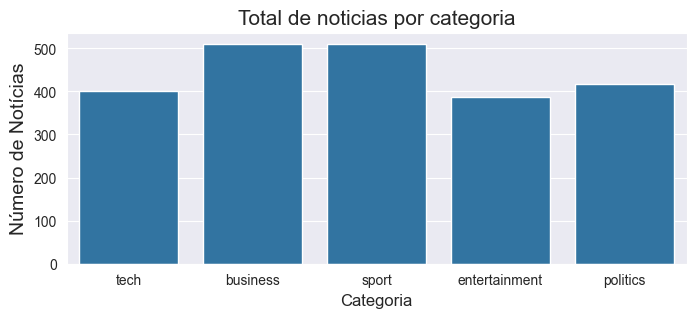

In [8]:
plt.figure(figsize=(8, 3))
sns.countplot(x = df_raw.category)
plt.title('Total de noticias por categoria', size=15)
plt.xlabel('Categoria', size=12)
plt.ylabel('Número de Notícias', size=14)
plt.show()

## Pré-processamento de Texto

In [9]:
df = df_raw.copy()

In [10]:
def clean_text(text):

    #regex to clean the text
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-zA-Z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r'\[[^()]*\]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(?:@\S*|#\S*|http(?=.*://)\S*)', ' ', text)
    text = text.lower()

    #remove stopwords
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    #word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [11]:
print('Original Text: ', df['text'][0])
print('Cleaned Text: ', clean_text(df['text'][0]))

Original Text:  tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being b

In [12]:
df['text'] = df['text'].apply(clean_text)

Workflow de Tokenização e Vetorização - One Hot Encoding a nível de palavra

In [13]:
samples = list(df['text'][:5].values)

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

max_length = 15

results = np.zeros((len(samples), 
                    max_length, 
                    max(token_index.values()) + 1))

print('Shape of results:', results.shape)
print('Token Index:', token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

print('Results Example:', results[0])

Shape of results: (5, 15, 680)
Token Index: {'tv': 1, 'future': 2, 'hand': 3, 'viewers': 4, 'home': 5, 'theatre': 6, 'systems': 7, 'plasma': 8, 'highdefinition': 9, 'tvs': 10, 'digital': 11, 'video': 12, 'recorders': 13, 'move': 14, 'live': 15, 'room': 16, 'way': 17, 'people': 18, 'watch': 19, 'will': 20, 'radically': 21, 'different': 22, 'five': 23, 'years': 24, 'time': 25, 'accord': 26, 'expert': 27, 'panel': 28, 'gather': 29, 'annual': 30, 'consumer': 31, 'electronics': 32, 'show': 33, 'las': 34, 'vegas': 35, 'discuss': 36, 'new': 37, 'technologies': 38, 'impact': 39, 'one': 40, 'favourite': 41, 'pastimes': 42, 'us': 43, 'lead': 44, 'trend': 45, 'program': 46, 'content': 47, 'deliver': 48, 'via': 49, 'network': 50, 'cable': 51, 'satellite': 52, 'telecoms': 53, 'company': 54, 'broadband': 55, 'service': 56, 'providers': 57, 'front': 58, 'portable': 59, 'devices': 60, 'talkedabout': 61, 'ces': 62, 'personal': 63, 'dvr': 64, 'pvr': 65, 'settop': 66, 'box': 67, 's': 68, 'tivo': 69, 'uk'

### Preparando dados

In [60]:
X = df['text']

encoder = LabelEncoder()
y = encoder.fit_transform(df['category'])

print('X Shape:', X.shape)
print('Y Shape:', y.shape)

X Shape: (2225,)
Y Shape: (2225,)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
print('X Train Shape:', X_train.shape)
print('X Test Shape:', X_test.shape)

X Train Shape: (1780,)
X Test Shape: (445,)


In [63]:
def tokenize_and_build_vocab(texts, num_words=1000, oov_token='<oov>'):
    tokenized_texts = [word_tokenize(text) for text in texts]
    counter = Counter()
    for tokens in tokenized_texts:
        counter.update(tokens)
    most_common = counter.most_common(num_words - 1)  # Reservando um espaço para o token OOV
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}  # Começando os índices a partir de 1
    vocab[oov_token] = 0  # Token OOV terá índice 0
    return vocab, tokenized_texts

def tokens_to_indices(tokens, vocab, oov_token='<oov>'):
    return [vocab.get(token, vocab[oov_token]) for token in tokens]

def preprocess_texts(tokenized_texts, vocab, maxlen=200):
    sequences = [torch.tensor(tokens_to_indices(tokens, vocab)) for tokens in tokenized_texts]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    if padded_sequences.size(1) > maxlen:
        padded_sequences = padded_sequences[:, :maxlen]
    else:
        padded_sequences = F.pad(padded_sequences, (0, maxlen - padded_sequences.size(1)), value=0)
    return padded_sequences

In [64]:
vocab, tokenized_texts_train = tokenize_and_build_vocab(X_train)
train_padseq = preprocess_texts(tokenized_texts_train, vocab, maxlen=200)

tokenized_texts_test = [word_tokenize(text.lower()) for text in X_test]
test_padseq = preprocess_texts(tokenized_texts_test, vocab, maxlen=200)

In [65]:
print('Train Pad Sequence Shape:', train_padseq.shape)
print('Test Pad Sequence Shape:', test_padseq.shape)

Train Pad Sequence Shape: torch.Size([1780, 200])
Test Pad Sequence Shape: torch.Size([445, 200])


In [70]:
y_train_hot = nn.functional.one_hot(torch.tensor(y_train), num_classes=5)
y_test_hot = nn.functional.one_hot(torch.tensor(y_test), num_classes=5)
y_train_float = y_train_hot.float()
y_test_float = y_test_hot.float()

In [72]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Criando os Datasets de treino e teste
train_dataset = TextDataset(train_padseq, y_train_float)
test_dataset = TextDataset(test_padseq, y_test_float)

# Criando os DataLoaders de treino e teste
train_loader = DataLoader(train_dataset, batch_size=120, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=120, shuffle=False)


### Treinando RNN

In [21]:
len(vocab)

1000

In [114]:
vocab_size = len(vocab)
embedding_dim = 70
max_len = 200
hidden_dim = 64
output_dim = 5

class simpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(simpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        return self.fc(hidden.squeeze(0))

class customRNN(nn.Module):
    def __init__(self, total_words, embedding_dim, maxlen):
        super(customRNN, self).__init__()
        self.embedding = nn.Embedding(total_words, embedding_dim)
        self.rnn1 = nn.RNN(embedding_dim, 64, batch_first=True, bidirectional=True, dropout=0.2)
        self.rnn2 = nn.RNN(128, 64, batch_first=True, bidirectional=True, dropout=0.3)  # 128 because it's bidirectional (64*2)
        self.rnn3 = nn.RNN(128, 32, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)
        self.dense = nn.Linear(32, 5)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = self.dropout3(x[:, -1, :])  # Only take the output of the last time step
        x = self.dense(x)
        return torch.softmax(x, dim=1)


#model = simpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim).to(DEVICE)
DEVICE = torch.device('cpu')
model = customRNN(vocab_size, embedding_dim, max_len).to(DEVICE)

/Users/zfab/repos/postech/f5-deep-learning/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/zfab/repos/postech/f5-deep-learning/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [115]:
def train(train_loader, model):

    model.train()

    epoch_loss = []
    predict_list, target_list = np.array([]), np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        output = model(data)
        loss = loss_fn(output, target)

        #metrics
        epoch_loss.append(loss.item())
        _, predict = torch.max(output, 1)
        _, target = torch.max(target, 1)
        predict_list = np.concatenate((predict_list, predict.cpu().numpy()))
        target_list = np.concatenate((target_list, target.cpu().numpy()))

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    acc = metrics.accuracy_score(predict_list, target_list)
    
    print(f"TRAIN - Loss: {np.mean(epoch_loss)} - Acc: {acc}")

    return epoch_loss, acc

def validate(test_loader, model):

    model.eval()

    epoch_loss = []
    predict_list, target_list = np.array([]), np.array([])
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            
            output = model(data)
            loss = loss_fn(output, target)

            #metrics
            epoch_loss.append(loss.item())
            _, predict = torch.max(output, 1)
            _, target = torch.max(target, 1)
            predict_list = np.concatenate((predict_list, predict.cpu().numpy()))
            target_list = np.concatenate((target_list, target.cpu().numpy()))

    acc = metrics.accuracy_score(predict_list, target_list)
    
    print(f"VALIDATE - Loss: {np.mean(epoch_loss)} - Acc: {acc}")

    return epoch_loss, acc

def fit(train_loader, test_loader, model, epochs):
    epoch_loss_train = []
    epoch_loss_test = []
    epoch_acc_train = []
    epoch_acc_test = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} -------------------------------")
        train_loss, train_acc = train(train_loader, model)
        test_loss, test_acc = validate(test_loader, model)
        
        epoch_loss_train.append(np.mean(train_loss[0]))
        epoch_loss_test.append(np.mean(test_loss[0]))
        epoch_acc_train.append(train_acc)
        epoch_acc_test.append(test_acc)

        print("\n")

    print(f"Final Loss Train: {epoch_loss_train[-1]} - Final Loss Test: {epoch_loss_test[-1]}")
    print(f"Final Acc Train: {epoch_acc_train[-1]} - Final Acc Test: {epoch_acc_test[-1]}")

    return epoch_loss_train, epoch_loss_test, epoch_acc_train, epoch_acc_test

In [116]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

epoch_loss_train, epoch_loss_test, epoch_acc_train, epoch_acc_test = fit(train_loader, test_loader, model, 50)

Epoch 1 -------------------------------
TRAIN - Loss: 1.598538303375244 - Acc: 0.23146067415730337
VALIDATE - Loss: 1.5933503210544586 - Acc: 0.24269662921348314


Epoch 2 -------------------------------
TRAIN - Loss: 1.575931692123413 - Acc: 0.298314606741573
VALIDATE - Loss: 1.5896617770195007 - Acc: 0.26741573033707866


Epoch 3 -------------------------------
TRAIN - Loss: 1.5667720079421996 - Acc: 0.30280898876404494
VALIDATE - Loss: 1.587867021560669 - Acc: 0.25842696629213485


Epoch 4 -------------------------------
TRAIN - Loss: 1.5516036430994669 - Acc: 0.33370786516853934
VALIDATE - Loss: 1.5861789286136627 - Acc: 0.25842696629213485


Epoch 5 -------------------------------
TRAIN - Loss: 1.538290524482727 - Acc: 0.34269662921348315
VALIDATE - Loss: 1.583765983581543 - Acc: 0.27191011235955054


Epoch 6 -------------------------------
TRAIN - Loss: 1.5226527770360312 - Acc: 0.36741573033707864
VALIDATE - Loss: 1.581311196088791 - Acc: 0.28314606741573034


Epoch 7 ----------

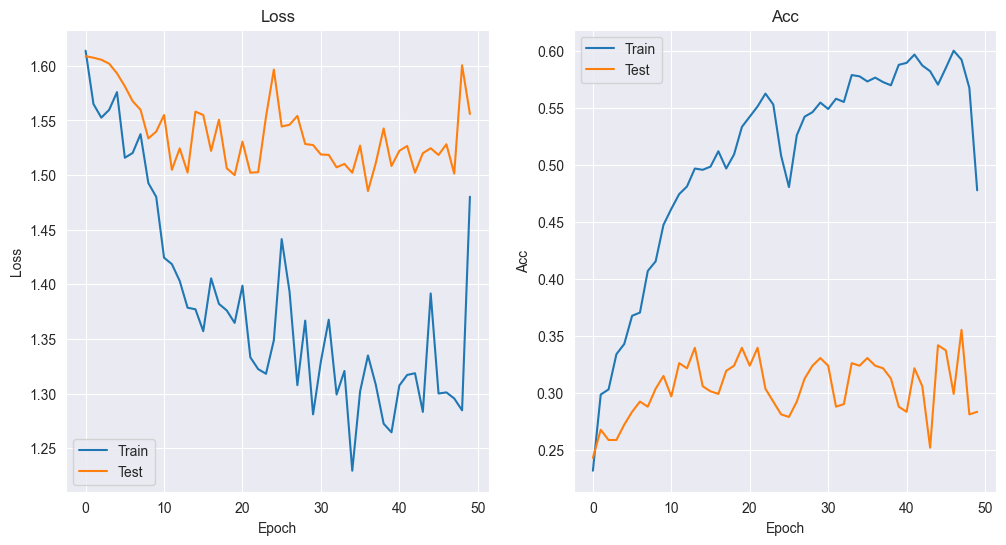

In [117]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_train, label='Train')
plt.plot(epoch_loss_test, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_acc_train, label='Train')
plt.plot(epoch_acc_test, label='Test')
plt.title('Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()


In [125]:
class LSTMGRUModel(nn.Module):
    def __init__(self, total_words, embedding_dim, maxlen):
        super(LSTMGRUModel, self).__init__()
        self.embedding = nn.Embedding(total_words, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, 64, batch_first=True, bidirectional=True, dropout=0.1)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True, bidirectional=True, dropout=0.2)
        self.rnn = nn.RNN(128, 64, batch_first=True, bidirectional=True, dropout=0.2)
        self.conv1d = nn.Conv1d(128, 72, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.rnn2 = nn.RNN(72, 64, batch_first=True, dropout=0.2)
        self.gru = nn.GRU(64, 64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(64, 5)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.rnn(x)
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, channels, seq_len) for Conv1D
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)  # Rearrange back to (batch_size, seq_len, channels) for RNN
        x, _ = self.rnn2(x)
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :])  # Only take the output of the last time step
        x = self.dense(x)
        return torch.softmax(x, dim=1)

DEVICE = torch.device('cpu')
model = LSTMGRUModel(vocab_size, embedding_dim, max_len).to(DEVICE)

/Users/zfab/repos/postech/f5-deep-learning/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/zfab/repos/postech/f5-deep-learning/.venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [127]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_loss_train, epoch_loss_test, epoch_acc_train, epoch_acc_test = fit(train_loader, test_loader, model, 20)

Epoch 1 -------------------------------
TRAIN - Loss: 1.5664795796076456 - Acc: 0.27752808988764044
VALIDATE - Loss: 1.5672219395637512 - Acc: 0.2853932584269663


Epoch 2 -------------------------------
TRAIN - Loss: 1.5617062012354532 - Acc: 0.2803370786516854
VALIDATE - Loss: 1.5678532719612122 - Acc: 0.298876404494382


Epoch 3 -------------------------------
TRAIN - Loss: 1.5492074728012084 - Acc: 0.31235955056179776
VALIDATE - Loss: 1.572238177061081 - Acc: 0.28314606741573034


Epoch 4 -------------------------------
TRAIN - Loss: 1.5549561023712157 - Acc: 0.3095505617977528
VALIDATE - Loss: 1.5478326380252838 - Acc: 0.3303370786516854


Epoch 5 -------------------------------
TRAIN - Loss: 1.5532423496246337 - Acc: 0.3039325842696629
VALIDATE - Loss: 1.5456320345401764 - Acc: 0.31910112359550563


Epoch 6 -------------------------------
TRAIN - Loss: 1.5413509607315063 - Acc: 0.32078651685393256
VALIDATE - Loss: 1.5575165748596191 - Acc: 0.30112359550561796


Epoch 7 ----------

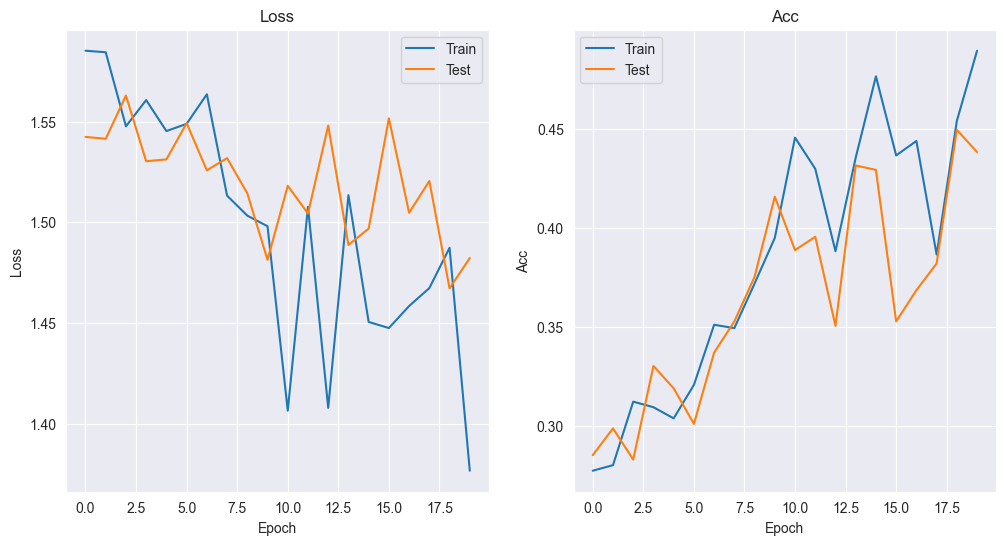

In [128]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss_train, label='Train')
plt.plot(epoch_loss_test, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_acc_train, label='Train')
plt.plot(epoch_acc_test, label='Test')
plt.title('Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()